In [3]:
# Treinamento de uam rede CNN para classificação de imagens de mamografia

# Importando as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

import pandas as pd

# Carregando os dados

WORK_DIR = os.getcwd()
UP_DIR = os.path.dirname(WORK_DIR)
UP_DIR = os.path.dirname(UP_DIR)
DATADIR = os.path.join(UP_DIR, 'data', 'cbis-ddsm')
CATEGORIES = ['BENIGN', 'MALIGNANT']

# csv com os dados das imagens
df_train = pd.read_csv(os.path.join(DATADIR, 'Train', 'clean_mass_train_description2.csv'))
df_test = pd.read_csv(os.path.join(DATADIR, 'Test', 'clean_mass_test_description2.csv'))

# Verificando os dados
print(df_train.head())
print(df_test.head())

# Verificando o tamanho dos dados
print(df_train.shape)
print(df_test.shape)

# Verificando a distribuição das classes
print(df_train['pathology'].value_counts())
print(df_test['pathology'].value_counts())

# Verificando a distribuição das classes
print(df_train['breast_density'].value_counts())
print(df_test['breast_density'].value_counts())

# Verificando a distribuição das classes
print(df_train['left or right breast'].value_counts())
print(df_test['left or right breast'].value_counts())


# Exclude Begnin withouth callback
df_train = df_train[df_train['pathology'] != 'BENIGN_WITHOUT_CALLBACK']
df_test = df_test[df_test['pathology'] != 'BENIGN_WITHOUT_CALLBACK']


# Verificando a distribuição das classes
print(df_train['pathology'].value_counts())
print(df_test['pathology'].value_counts())


  patient_id  breast_density left or right breast  pathology  \
0    P_00001               3                 LEFT  MALIGNANT   
1    P_00004               3                 LEFT     BENIGN   
2    P_00009               3                RIGHT  MALIGNANT   
3    P_00018               2                RIGHT     BENIGN   
4    P_00021               1                 LEFT     BENIGN   

                        image file path  
0   Mass-Training_P_00001_LEFT_CC_1.png  
1   Mass-Training_P_00004_LEFT_CC_1.png  
2  Mass-Training_P_00009_RIGHT_CC_1.png  
3  Mass-Training_P_00018_RIGHT_CC_1.png  
4   Mass-Training_P_00021_LEFT_CC_1.png  
  patient_id  breast_density left or right breast  pathology  \
0    P_00016               4                 LEFT  MALIGNANT   
1    P_00017               2                 LEFT  MALIGNANT   
2    P_00032               3                RIGHT     BENIGN   
3    P_00037               3                RIGHT  MALIGNANT   
4    P_00066               4               

In [4]:
# imports para processamento dos dados 
import cv2
from sklearn.model_selection import train_test_split


# Preparando os dados

CATEGORIES = ['BENIGN', 'MALIGNANT']
IMG_SIZE = 224
def create_training_data(df, img_size, categories, datadir):
    training_data = []
    for index, row in df.iterrows():
        try:
            img_array = plt.imread(os.path.join(datadir, row['image file path']))
            new_array = cv2.resize(img_array, (img_size, img_size))
            # Normalizing the data
            # To Numpy array
            new_array = np.array(new_array)
            training_data.append([new_array, categories.index(row['pathology'])])
            # Benign = 0, Malignant = 1
                        

            print(index)
        except Exception as e:
            print(e)
            pass
    return training_data

train_data = create_training_data(df_train, IMG_SIZE, CATEGORIES, os.path.join(DATADIR, 'Train', 'Train'))
testing_data = create_training_data(df_test, IMG_SIZE, CATEGORIES, os.path.join(DATADIR, 'Test', 'Test'))

# Verificando o tamanho dos dados
print(len(train_data))
print(len(testing_data))

# Verificando os dados
print(train_data[0])
print(testing_data[0])

# Embaralhando os dados
random.shuffle(train_data)
random.shuffle(testing_data)


# Separando os dados
X_train = []
y_train = []
for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

X_test = []
y_test = []
for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)


# Convertendo para numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)



0
1
2
3
4
5
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
119
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
210
211
212
213
214
215
216
217
218
219
220
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
241
242
243
244
245
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
29

KeyboardInterrupt: 

In [ ]:
# Métricas de media e desvio padrão dos dados
print(X_train.shape)
print(X_test.shape)
print(np.mean(X_train))
print(np.std(X_train))
print(np.mean(X_test))
print(np.std(X_test))


# normalizar para obter média 0.46 e desvio padrão 0.22
#X_train = 0.22/np.std(X_train)*(X_train)
#X_test = 0.22/np.std(X_test)*(X_test)

#X_train = 0.46 - np.mean(X_train) + X_train
#X_test = 0.46 - np.mean(X_test) + X_test


# Métricas de media e desvio padrão dos dados
print(X_train.shape)
print(X_test.shape)
print(np.mean(X_train))
print(np.std(X_train))

# Merge data and separate in train and test
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Adaptative Contrast
def adaptative_contrast(X):
    X_adaptative = np.zeros(X.shape)
    for i in range(X.shape[0]):
        X_adaptative[i] = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(X[i].astype(np.uint8))
    return X_adaptative

#X = adaptative_contrast(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Métricas de media e desvio padrão dos dados
print(X_train.shape)
print(X_test.shape)
print(np.mean(X_train))
print(np.std(X_train))
print(np.mean(X_test))
print(np.std(X_test))

# To 3 channels
X_train = np.stack((X_train,)*3, axis=-1)
X_test = np.stack((X_test,)*3, axis=-1)



(569, 224, 224)
(161, 224, 224)
0.72623813


0.16412063
0.7386325
0.16494966
(569, 224, 224)
(161, 224, 224)
0.72623813
0.16412063
(584, 224, 224)
(146, 224, 224)
0.72878945
0.16490328
0.7297002
0.16228926


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 activation_9 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 activation_10 (Activation)  (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                 

/home/vdgaete/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 - 0s - loss: 2.3482 - accuracy: 0.5068 - 117ms/epoch - 23ms/step
0.5068492889404297
5/5 [==============================] - 0s 18ms/step
[[9.9626678e-01]
 [9.7396302e-01]
 [5.6477737e-01]
 [5.3566318e-02]
 [1.3583133e-08]
 [9.9924880e-01]
 [9.8659676e-01]
 [4.5859677e-01]
 [3.8615334e-01]
 [1.0254103e-03]
 [8.5990191e-01]
 [7.7975518e-01]
 [6.5391535e-01]
 [6.3874617e-02]
 [1.4471042e-03]
 [9.9367493e-01]
 [9.8462439e-01]
 [1.5637790e-01]
 [7.1509909e-03]
 [9.9981719e-01]
 [9.7350854e-01]
 [8.7531561e-01]
 [5.8924681e-01]
 [9.9598181e-01]
 [2.0016254e-05]
 [9.6682513e-01]
 [4.9129841e-01]
 [1.1680694e-10]
 [9.9947029e-01]
 [4.1586719e-02]
 [2.7155324e-05]
 [6.4797478e-04]
 [1.1421105e-01]
 [6.4603919e-01]
 [8.0029422e-01]
 [9.7287941e-01]
 [9.1863446e-02]
 [4.4881186e-01]
 [9.2370862e-01]
 [8.6774814e-01]
 [2.3453349e-01]
 [7.0500723e-03]
 [5.5521585e-05]
 [9.9405259e-01]
 [4.2900836e-01]
 [9.7379082e-01]
 [9.7036695e-01]
 [4.6142051e-13]
 [6.6236657e-01]
 [5.6667757e-01]
 [9.731898

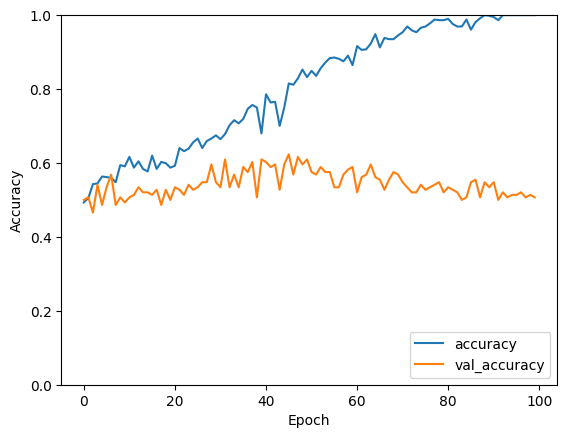

In [ ]:
# Testando o modelo com CNN simples
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

model.summary()

# Treinando o modelo
history = model.fit(X_train, y_train, batch_size=10, epochs=20, validation_data=(X_test, y_test))

# Salvando o modelo
model.save(os.path.join(WORK_DIR, 'cnn_model.h5'))


# Plotando o histórico de treinamento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

# Previsões
predictions = model.predict(X_test)
print(predictions)

# Comparando as previsões com os dados reais
for i in range(10):
    print(predictions[i])
    print(y_test[i])
    print('-----------------')


In [ ]:
# Cleaning GPU memory
tf.keras.backend.clear_session()



# Teste com modelo pre-treinado VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Carregando o modelo
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelando as camadas 
for layer in vgg16.layers:
    layer.trainable = False


# Adicionando camadas
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Camada de saída com ativação sigmóide
preds = Dense(1, activation='sigmoid')(x)

# Criando o modelo
model = Model(inputs=vgg16.input, outputs=preds)

# Visualizando o modelo
model.summary()


# Otimizador
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)
# Compilando o modelo
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o classificador
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))

# Salvando o modelo
model.save('vgg16_model.h5')

# congelando o classificador
for layer in model.layers:
    layer.trainable = False

# Summary
model.summary()

# Descongelando camadas 12 a 15
for layer in model.layers[12:15]:
    layer.trainable = True

# Otimizador
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)

# Compilando o modelo
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

# Salvando o modelo
model.save('vgg16_step2_model.h5')


# Avaliando o modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])

# Plotando a acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotando a perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predições
predictions = model.predict(X_test)
print(predictions)



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

2024-02-26 17:36:11.087431: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.19MiB (rounded to 9633792)requested by op model_5/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-26 17:36:11.087500: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-26 17:36:11.087513: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 283, Chunks in use: 282. 70.8KiB allocated for chunks. 70.5KiB in use in bin. 15.7KiB client-requested in use in bin.
2024-02-26 17:36:11.087518: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.8KiB allocated for chunks. 6.8KiB in use in bin. 6.0KiB

ResourceExhaustedError: Graph execution error:

Detected at node model_5/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[16,3,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/block1_conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_81367]

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

/home/vdgaete/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test loss: 0.70890212059021


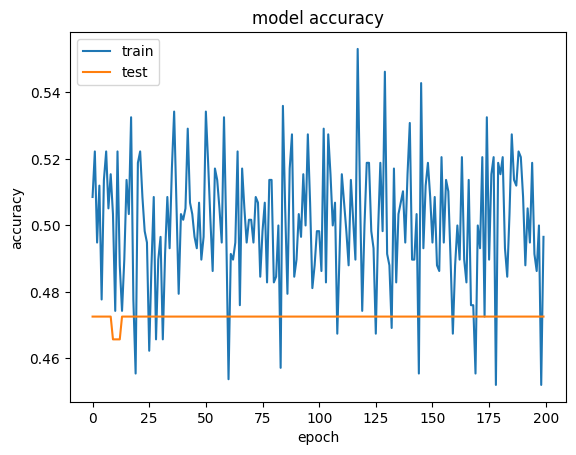

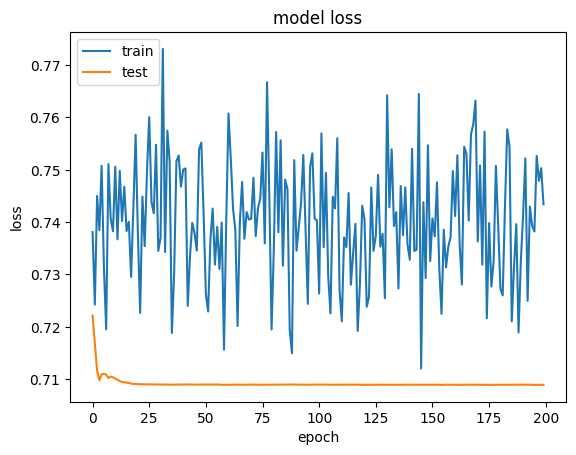

5/5 [==============================] - 1s 106ms/step
[[0.537054  ]
 [0.5451338 ]
 [0.5388318 ]
 [0.55298126]
 [0.5621937 ]
 [0.55159247]
 [0.5723249 ]
 [0.5418037 ]
 [0.55056435]
 [0.54115057]
 [0.5351206 ]
 [0.547955  ]
 [0.5448392 ]
 [0.5594186 ]
 [0.5502613 ]
 [0.55032486]
 [0.5571284 ]
 [0.53379273]
 [0.539717  ]
 [0.5334568 ]
 [0.55908126]
 [0.58311456]
 [0.55137813]
 [0.5368858 ]
 [0.54337287]
 [0.54412425]
 [0.55666375]
 [0.5594477 ]
 [0.56294066]
 [0.5722941 ]
 [0.56377393]
 [0.55643123]
 [0.534135  ]
 [0.5658687 ]
 [0.54886645]
 [0.56798875]
 [0.5558985 ]
 [0.54677963]
 [0.56408536]
 [0.5550803 ]
 [0.54076546]
 [0.5511764 ]
 [0.56587124]
 [0.543038  ]
 [0.5492544 ]
 [0.5526174 ]
 [0.5454263 ]
 [0.56476164]
 [0.5546659 ]
 [0.5639127 ]
 [0.5589152 ]
 [0.5500148 ]
 [0.5697679 ]
 [0.5500086 ]
 [0.5436563 ]
 [0.553424  ]
 [0.5349542 ]
 [0.55681455]
 [0.5593691 ]
 [0.56023943]
 [0.5488874 ]
 [0.5609016 ]
 [0.48235905]
 [0.56566316]
 [0.5299    ]
 [0.55219847]
 [0.5457114 ]
 [0.56355

In [ ]:
# Teste com modelo pre-treinado RESNET50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D





# Carregando o modelo
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelando as camadas Deixando as ultimas 10 camadas para treinamento
for layer in resnet50.layers[:-10]:
    layer.trainable = False



# Adicionando camadas
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# Camada de saída com ativação sigmóide
preds = Dense(1, activation='sigmoid')(x)

# Criando o modelo
model = Model(inputs=resnet50.input, outputs=preds)

# Visualizando o modelo
model.summary()

# Otimizador
sgd = tf.keras.optimizers.SGD(learning_rate=1e-8)

# Compilando o modelo
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

# Salvando o modelo
model.save('resnet50_model.h5')

# Avaliando o modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])

# Plotando a acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotando a perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predições
predictions = model.predict(X_test)
print(predictions)




In [ ]:
# Teste com modelo pre-treinado MOBILENETV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Carregando o modelo
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Congelando as camadas Deixando as ultimas 3 camadas para treinamento
for layer in mobilenetv2.layers[:-3]:
    layer.trainable = False


# Adicionando camadas
x = mobilenetv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
# Camada de saída com ativação sigmóide
preds = Dense(1, activation='sigmoid')(x)

# Criando o modelo
model = Model(inputs=mobilenetv2.input, outputs=preds)

# Visualizando o modelo
model.summary()

# Otimizador
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9, nesterov=True)

# Compilando o modelo
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, batch_size=16, epochs=200, validation_data=(X_test, y_test))

# Salvando o modelo
model.save('mobilenetv2_model.h5')

# Avaliando o modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])

# Plotando a acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotando a perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predições
predictions = model.predict(X_test)
print(predictions)



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

KeyboardInterrupt: 